In [1]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import os
import copy
import pandas as pd
import random


from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, Dataset, DataLoader
from torch.optim import lr_scheduler
from torch import nn, optim
from torch.autograd import Variable
from __future__ import print_function, division


In [2]:
plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\Moon\Anaconda3\envs\deeplearning\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
#Helper functions

def image_prob(image_class_no = 1, prob = 1):
    image_index = []
    for x in range(40):
        image_index.insert(x, 0)
    image_index[image_class_no-1] = prob

    return image_index

def epoch_time(start_time,
               end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

def weight_inits(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        
def plot_img(images):
    x = images.detach().numpy()
    pic = x[0,0,:,:]
    return pic


In [4]:
#network architecture.
#This simple network will use to train the model

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(16*21*26 , 8736)
        self.fc2 = nn.Linear(8736, 84)
        self.fc3   = nn.Linear(84, 40)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 16 * 21* 26)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    

In [5]:
# from torchsummary import summary
# model = Network()
# summary(model, (3, 92, 112))

In [6]:
def train_model(model, criterion, optimizer, data_loader, scheduler, num_epochs=20):
    print("Model trainig sart...")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()

        for phase in ['train']:
            
            if phase == 'train':
                model.train() 
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in data_loader:
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                end_time = time.time()
                scheduler.step()
                
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size
                epoch_mins, epoch_secs = epoch_time(start_time, end_time)

                print(f'Epoch: {epoch}/{num_epochs - 1} | Time: {epoch_mins}m {epoch_secs}s')
                print('{} Loss: {:.3f} Acc: {:.3f}'.format('Train', epoch_loss, epoch_acc))

In [7]:
def test_model(model, criterion, optimizer, data_loader):
    model.eval()  
                
    running_loss = 0.0
    running_corrects = 0

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / test_size
    epoch_acc = running_corrects.double() / test_size

    print('{} Loss: {:.3f} Acc: {:.3f}'.format('Val', epoch_loss, epoch_acc))

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dir = "/UdS Study/SuSe 2021/PET/pp/att_faces"

orig_set  = ImageFolder(root=dir, transform=transform)
n = len(orig_set) 
n_test = int(0.2 * n)  # take ~20% for test
test_dataset = torch.utils.data.Subset(orig_set, range(n_test))  # take first 20%
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                         shuffle=False, num_workers=2)

train_dataset = torch.utils.data.Subset(orig_set, range(n_test, n))  # take the rest 80%
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)


In [9]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

shuffle = True
random_seed = 28
batch_size = 32
num_workers = 1
pin_memory = False
train_dataset = datasets.ImageFolder(root=dir, transform=transform)

valid_dataset = datasets.ImageFolder(root=dir, transform=transform)

num_train = len(train_dataset)
indices = list(range(num_train))
valid_size = 0.2
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory)

In [10]:
train_size = len(train_loader) * batch_size
test_size = 80
net = Network()
net.apply(weight_inits)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(net.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

train_model(net, criterion, optimizer_ft, train_loader, exp_lr_scheduler,
                       num_epochs=10)

Model trainig sart...
Epoch: 0/9 | Time: 0m 20s
Train Loss: 42.990 Acc: 0.019
Epoch: 1/9 | Time: 0m 17s
Train Loss: 8.725 Acc: 0.166
Epoch: 2/9 | Time: 0m 17s
Train Loss: 3.220 Acc: 0.325
Epoch: 3/9 | Time: 0m 17s
Train Loss: 1.639 Acc: 0.662
Epoch: 4/9 | Time: 0m 17s
Train Loss: 0.880 Acc: 0.828
Epoch: 5/9 | Time: 0m 17s
Train Loss: 0.420 Acc: 0.922
Epoch: 6/9 | Time: 0m 17s
Train Loss: 0.248 Acc: 0.938
Epoch: 7/9 | Time: 0m 17s
Train Loss: 0.203 Acc: 0.963
Epoch: 8/9 | Time: 0m 17s
Train Loss: 0.201 Acc: 0.966
Epoch: 9/9 | Time: 0m 17s
Train Loss: 0.150 Acc: 0.981


In [11]:
test_model(net, criterion, optimizer_ft, valid_loader)

Val Loss: 0.357 Acc: 0.900


In [16]:
path = './model_inversion.pt'
torch.save(net.state_dict(), path)

In [12]:
#Model Inversion: Type 2 implimentation

def MIFace(x, y, optimizer, model, epoch=1000):
    model.eval()
    
    for i in range(epoch):
        optimizer.zero_grad()
        prob = torch.softmax(model(x), -1)
        loss = y * prob.log()
        loss = - loss.sum(-1).mean()
        
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('Epoch {}/{}'.format(i/100+1, epoch/100))
            print('\tloss', loss.item())
            
    print("Training finished")
    x = torch.tanh(x)
    return x,y

In [13]:
#set the probability of the image class
y = torch.FloatTensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
x = torch.randn((1, 3, 92, 112), requires_grad=True)
optimizer = optim.Adam([x], lr=0.001)
images, labels = MIFace(x, y, optimizer, net, 1000)

Epoch 1.0/10.0
	loss 29.831201553344727
Epoch 2.0/10.0
	loss 0.008241306990385056
Epoch 3.0/10.0
	loss 0.004750730004161596
Epoch 4.0/10.0
	loss 0.0032310772221535444
Epoch 5.0/10.0
	loss 0.002344732405617833
Epoch 6.0/10.0
	loss 0.0017844256944954395
Epoch 7.0/10.0
	loss 0.0014060483081266284
Epoch 8.0/10.0
	loss 0.0011375457979738712
Epoch 9.0/10.0
	loss 0.0009398703696206212
Epoch 10.0/10.0
	loss 0.0007903121877461672
Training finished


In [14]:
def inversion_pred(net, data, image, label):
    
    true_class = data.classes[torch.argmax(label).item()]
    true_label = torch.argmax(label).item()
    print("True image label: {} ({})".format( true_class, true_label))

    img_prob = torch.softmax(net(image), -1)
    predict_class = orig_set.classes[img_prob.argmax().item()]
    predict_label = img_prob.argmax().item()

    print("Predicted image label: {} ({}) ".format( predict_class, predict_label))
    print("Probability for predicted the class: ", img_prob.max().item())

    plt.imshow(plot_img(image))

True image label: s11 (2)
Predicted image label: s14 (5) 
Probability for predicted the class:  0.5006840825080872


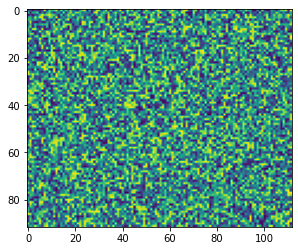

In [19]:
# load_net = Network()
# load_net.load_state_dict(torch.load('./model_inversion.pt'))
# inversion_pred(net=net, data = orig_set, image = images, label = labels)

inversion_pred(net=net, data = orig_set, image = images, label = labels)